In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pyjet import cluster,DTYPE_PTEPM
import fastjet as fj
import energyflow as ef
from tqdm import tqdm


# Pyjet

In [25]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [26]:
# Option 1: Load everything into memory
df = pandas.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [27]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [28]:
truth = np.array(df[2100])
print(truth.shape)
np.unique(truth,return_counts=True)

(1100000,)


(array([0., 1.]), array([1000000,  100000]))

In [29]:
events_combined_perm = np.array(df)[np.random.permutation(len(np.array(df)))]
print(np.shape(events_combined_perm))
#events_combined = events_combined[:, :10000]
#print(events_combined.shape)
print(events_combined_perm[:,2100])

(1100000, 2101)
[0. 0. 0. ... 0. 0. 0.]


In [30]:
events_combined = events_combined_perm[:10000]
print(np.unique(events_combined[:,2100],return_counts=True))
#events_combined = events_combined.T
#print(events_combined.shape)

(array([0., 1.]), array([9056,  944]))


In [31]:
phi = events_combined[:,::3]
print(phi.shape)
print(phi[0,:50])

(10000, 701)
[1.42892265e+00 1.88546753e+01 1.44286656e+00 2.00822639e+00
 5.11235762e+00 1.29668856e+00 1.16210854e+00 2.46102962e+01
 1.19334888e+03 1.78706951e+01 2.02429008e+00 2.81843615e+00
 4.91305828e+00 6.12278414e+00 2.40091648e+01 3.42726469e+00
 2.86559463e+00 3.72665954e+00 5.48907089e+00 1.16427708e+00
 1.23194039e+00 4.59656239e+00 2.97817492e+00 1.55548487e+01
 4.34041481e+01 2.49011564e+00 5.45455837e+00 6.25588322e+00
 1.00582218e+01 3.14952946e+00 2.29324989e+01 5.51959944e+00
 1.03214002e+00 4.13795185e+00 9.63368416e+00 1.27935400e+01
 1.86091633e+01 1.88274250e+01 6.50494003e+00 2.68546581e+00
 1.51869786e+00 1.24294114e+00 2.74682522e+00 2.85018611e+00
 1.12762451e+00 9.44766617e+00 4.94428968e+00 2.04212189e+01
 4.80730200e+00 4.05815649e+00]


## Clustering

In [32]:
#Now, let's cluster some jets!
leadpT = {}
first_jets = {}
alljets = {}
for mytype in ['background','signal']:
    leadpT[mytype]=[]
    alljets[mytype]=[]
    first_jets[mytype]=[]
    for i in range(np.shape(events_combined)[0]):
        if (i%1000==0):
            print(mytype,i)
            pass
        #print(f"events: {np.shape(events_combined[i])}")
        issignal = events_combined[i][2100]
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
            continue
        pseudojets_input = np.zeros(len([x for x in events_combined[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
        #print(np.shape(pseudojets_input))
        for j in range(700):
            if (events_combined[i][j*3]>0):
                pseudojets_input[j]['pT'] = events_combined[i][j*3]
                pseudojets_input[j]['eta'] = events_combined[i][j*3+1]
                pseudojets_input[j]['phi'] = events_combined[i][j*3+2]
                pass
            pass
        sequence = cluster(pseudojets_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)
        leadpT[mytype] += [jets[0].pt]
        first_jets[mytype] += [jets[0]]
        alljets[mytype] += [jets]
        pass

background 0
background 1000
background 2000
background 3000
background 4000
background 5000
background 6000
background 7000
background 8000
background 9000
signal 0
signal 1000
signal 2000
signal 3000
signal 4000
signal 5000
signal 6000
signal 7000
signal 8000
signal 9000


In [33]:
jets = alljets['background']
mass_sorted_jets = []
for jet in jets:
    jets_to_sort = jet[:2] # only sort the first two subjets with highest pT
    sorted_subjet = sorted(jets_to_sort,key=lambda x: x.mass,reverse=True)
    mass_sorted_jets.append(sorted_subjet)

In [34]:
#jets = mass_sorted_jets
jets = alljets['background']
x_masses = []
y_masses = []
x_jets = []
for jets in jets:
    #print(jets)
    x_jet = jets[0]
    y_jet = jets[1]
    x_jets.append(x_jet)
    #if (x_jet.mass < y_jet.mass):
    #    x_jet = jets[1]
    #    y_jet = jets[0]
    #    pass
    #x_jet_mass = sum([x.mass for x in x_jet])
    #y_jet_mass = sum([x.mass for x in y_jet])
    x_masses.append(x_jet.mass)
    y_masses.append(y_jet.mass)
x_jets = np.array(x_jets)

In [35]:
print(type(x_jets))
print(x_jets.shape)

<class 'numpy.ndarray'>
(9056,)


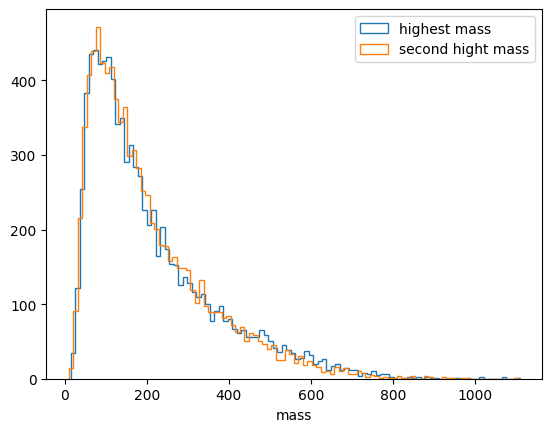

In [36]:
plt.hist(x_masses,bins=100, histtype='step',label='highest mass')
plt.hist(y_masses,bins=100, histtype='step',label='second hight mass')
plt.xlabel('mass')
plt.legend()
plt.show()

In [37]:
first_jets['signal'][2]

PseudoJet(pt=1417.681, eta=-0.721, phi=-0.600, mass=102.632)

In [273]:
print(len(first_jets['background']))
print(f"Jet pt: {first_jets['background'][0].pt}")
print(f"Jet eta: {first_jets['background'][0].eta}")
print(f"Jet phi: {first_jets['background'][0].phi}")
print(f"Jet mass: {first_jets['background'][0].mass}")

9080
Jet pt: 1540.7826399390697
Jet eta: -0.5792274276479966
Jet phi: -1.1388555705535621
Jet mass: 106.94746231707505


In [38]:
constituents = []
rel_constituents = []
len_constituents = []
mask = []
len_padding = 250
for jet in x_jets:
    const_temp = []
    # transform void struct to array
    for constituent_void in jet.constituents_array():
        array = np.asarray(constituent_void).tolist()
        const_temp.append(array)
    unpadded_consts = np.array(const_temp)
    mask_single_jet = np.ones(len(unpadded_consts))
    
    # pad constituents and mask
    padded_mask = np.pad(mask_single_jet,(0,len_padding-len(mask_single_jet)),'constant',constant_values=0)
    padded_consts = np.pad(unpadded_consts,((0,len_padding-len(unpadded_consts)),(0,0)),'constant',constant_values=0)
    
    # relative coordinates
    rel_constituents_temp = padded_consts.copy()
    rel_constituents_temp[:,0] = rel_constituents_temp[:,0]/jet.pt
    rel_constituents_temp[:,1] = rel_constituents_temp[:,1] - jet.eta
    rel_constituents_temp[:,2] = rel_constituents_temp[:,2] - jet.phi
    rel_constituents_temp[:,2] = np.where(rel_constituents_temp[:,2] > np.pi, rel_constituents_temp[:,2] - 2*np.pi, rel_constituents_temp[:,2])
    rel_constituents_temp[:,2] = np.where(rel_constituents_temp[:,2] < -np.pi, rel_constituents_temp[:,2] + 2*np.pi, rel_constituents_temp[:,2])
    
    constituents.append(padded_consts)
    rel_constituents.append(rel_constituents_temp)
    mask.append(padded_mask)
    len_constituents.append(len(jet.constituents_array()))
constituents = np.array(constituents)
rel_constituents = np.array(rel_constituents)
mask = np.array(mask)
print(f"max constituents: {np.max(len_constituents)}")
print(f"min constituents: {np.min(len_constituents)}")
print(constituents.shape)
print(mask.shape)


max constituents: 210
min constituents: 4
(9056, 250, 4)
(9056, 250)


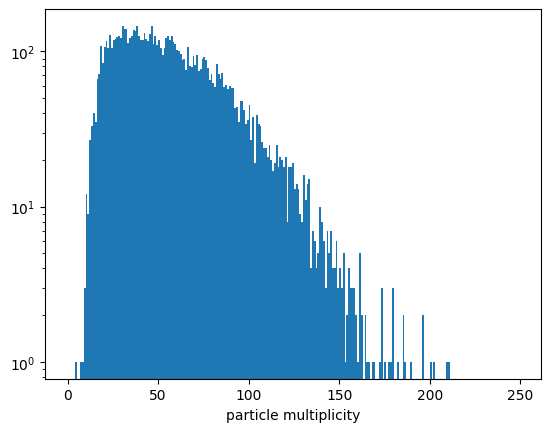

In [39]:
plt.hist(np.sum(mask,axis=-1), bins=range(0,250,1))
plt.xlabel('particle multiplicity')
plt.yscale('log')
plt.show()

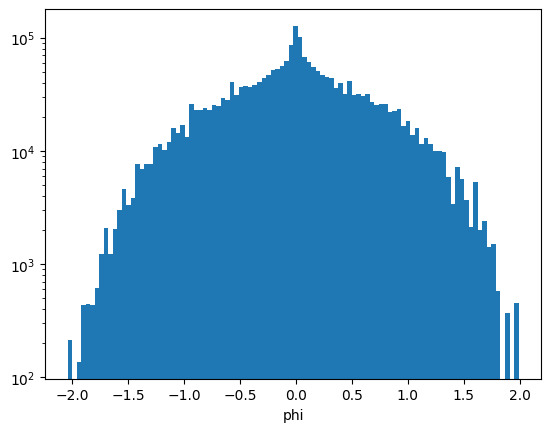

In [41]:
index = 1
plt.hist(rel_constituents[:,:,index].flatten()[rel_constituents[:, :, index].flatten() != 0],bins=100)
plt.xlabel(f'phi')
plt.yscale('log')
plt.show()

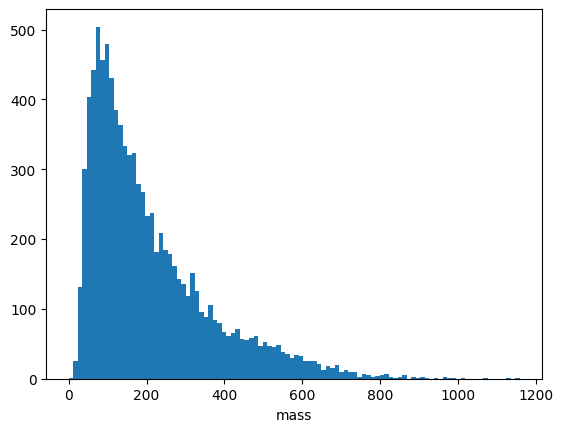

In [22]:
masses = []
for jet in x_jets:
    masses.append(jet.mass)
plt.hist(masses,bins=100)
plt.xlabel('mass')
plt.show()

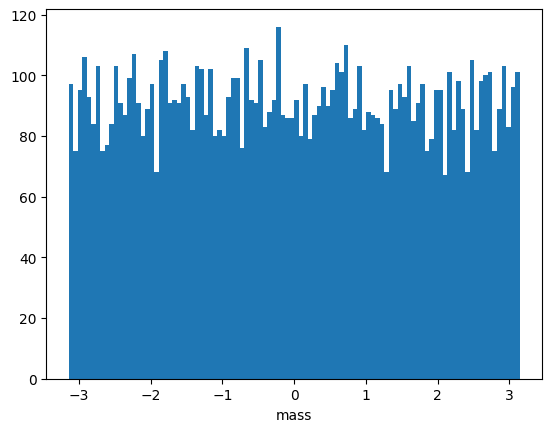

In [25]:
masses = []
for jet in x_jets:
    masses.append(jet.phi)
plt.hist(masses,bins=100)
plt.show()

In [26]:
p4s = ef.p4s_from_ptyphims(rel_constituents[:, :, :3])
sum_p4 = np.sum(p4s, axis=-2)
jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)

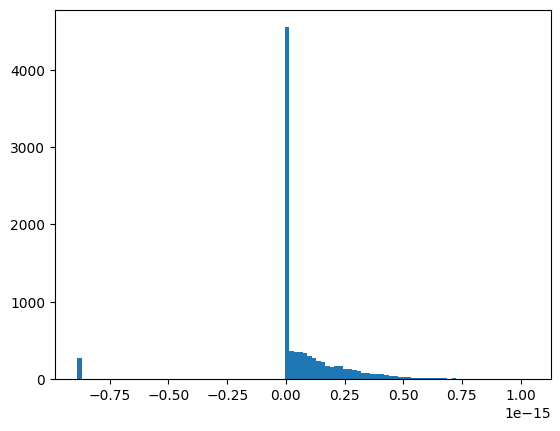

In [36]:
plt.hist(jet_data[:,2],bins=100)
plt.show()

In [83]:
background = alljets["background"]
print(len(background))

9080


In [98]:
print(leadpT["background"])

[1540.7826399390697, 1349.1983343457628, 1354.1409953601947, 1235.272772307667, 1524.065156689483, 1269.9260499772636, 1334.932750194237, 1725.9789655078382, 1338.8525429114397, 1623.084599003053, 1343.558576917352, 1318.9705560534564, 1311.9981846171083, 1216.750701995735, 1403.0995922583513, 1261.1445893762361, 1779.2158081274304, 1358.261416542775, 1219.4855005784402, 1286.8813025471404, 1250.2374218337275, 1590.5789245661013, 1280.7371810903082, 1238.3392831681654, 1262.8998907332343, 1420.9896789868014, 1372.2261322772717, 1398.7286671602853, 1265.2376582143422, 1898.1128759571973, 1402.7050174033097, 1258.4750287064774, 1617.322782476638, 1220.6135581694994, 1476.6641398967445, 1241.478491308405, 1245.4968987363513, 1329.2766418466365, 1458.6272339066873, 1464.702890830904, 1460.2563753239642, 1454.1376690257873, 1229.0555108936314, 1266.6770469381754, 1225.8206492820282, 1213.1576441175507, 1246.034513668485, 1702.6188094861707, 1211.2239035797857, 1210.963653013084, 1402.632249

In [95]:
print(len(background[200]))

3


In [75]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(alljets[mytype])):
        E = alljets[mytype][k][0].e+alljets[mytype][k][1].e
        px = alljets[mytype][k][0].px+alljets[mytype][k][1].px
        py = alljets[mytype][k][0].py+alljets[mytype][k][1].py
        pz = alljets[mytype][k][0].pz+alljets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]
        pass
    pass

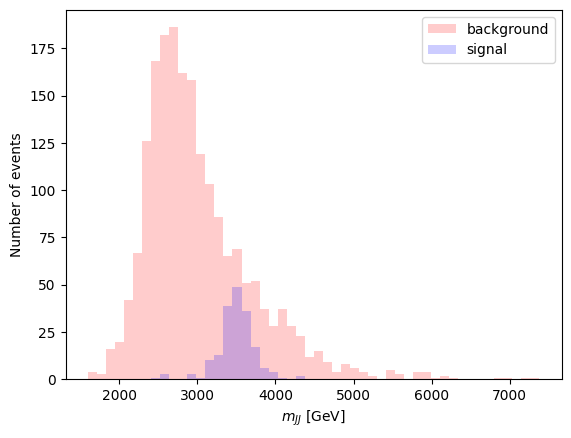

In [76]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.show()

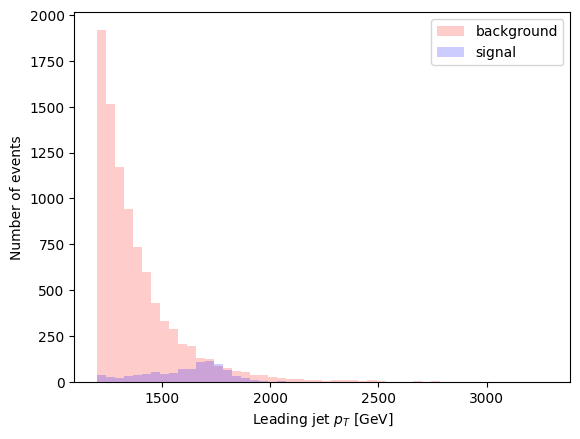

In [97]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadpT['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.show()

# Fastjet

In [3]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [4]:
# Option 1: Load everything into memory
df = pandas.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [5]:
np_array = np.array(df)
print(np_array.shape)
signal = np_array[np_array[:,2100]==1]
background = np_array[np_array[:,2100]==0]
print(signal.shape)
print(background.shape)

(1100000, 2101)
(100000, 2101)
(1000000, 2101)


In [6]:
background_reduced = background[: , :2100]
signal_reduced = background[: , :2100]
qcd_data = background_reduced.reshape(-1,700,3)
sig_data = signal_reduced.reshape(-1,700,3)
print(qcd_data.shape)
print(sig_data.shape)

(1000000, 700, 3)
(1000000, 700, 3)


In [7]:
print(qcd_data[0,0,:].shape)

(3,)


In [8]:
print(qcd_data[0,0,0])

1.840248942375183


In [9]:
jet = fj.PseudoJet(float(qcd_data[0,0,0]),float(qcd_data[0,0,1]),float(qcd_data[0,0,2]),0.)

In [91]:
data_pseudojets = []
for data in qcd_data[0]:
    data_pseudojets.append(fj.PseudoJet(float(data[0]),float(data[1]),float(data[2]),0.))
print(len(data_pseudojets))

700


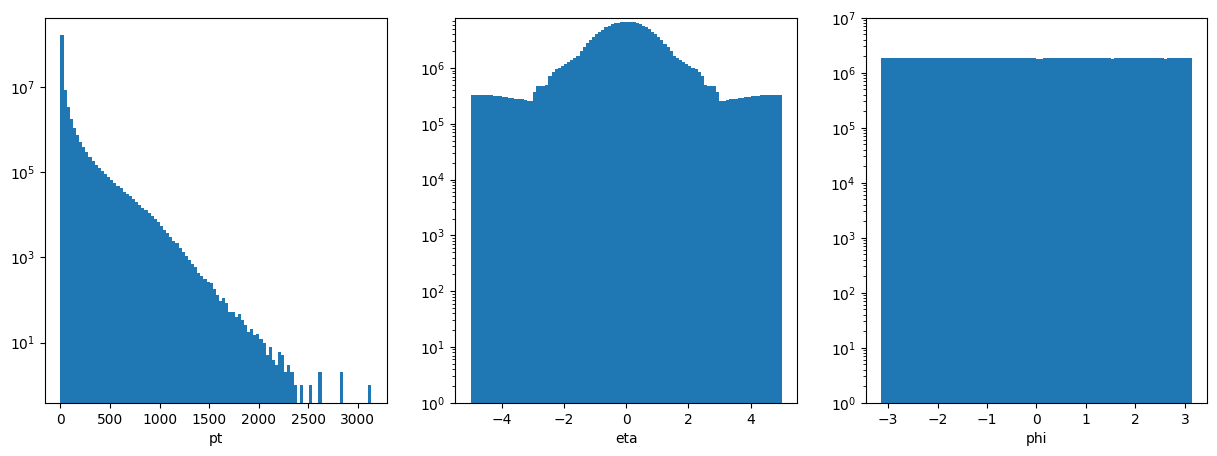

In [14]:
mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data[:, :, index].flatten()[qcd_data[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    if index == 1:
        ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
#plt.xlim(-5, 5)
#plt.title("QCD original data")
plt.show()

(1000000, 700, 3)


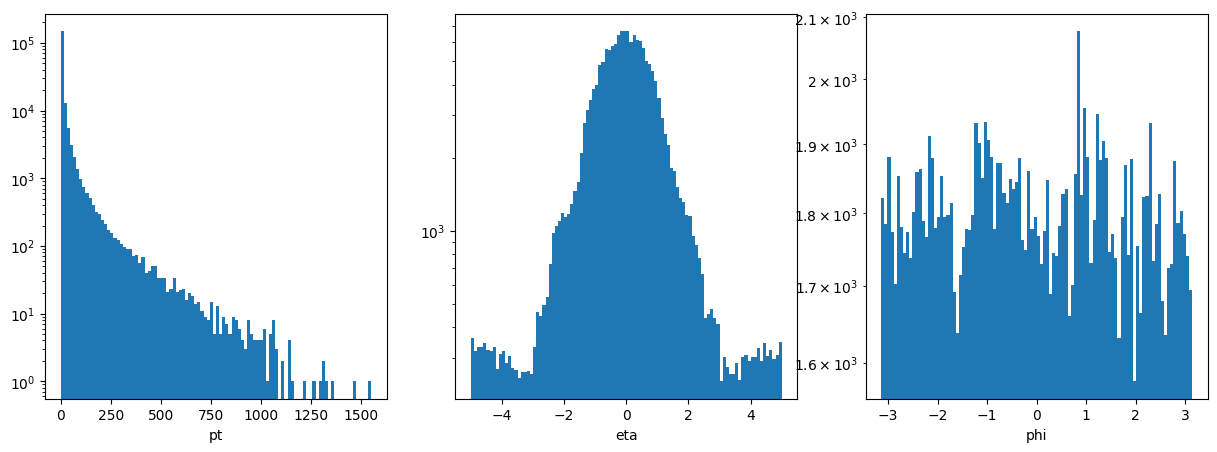

In [56]:
# only take the first 10000 events
print(qcd_data.shape)
qcd_data_small = qcd_data[:1000]
mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data_small[:, :, index].flatten()[qcd_data_small[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
#plt.xlim(-5, 5)
#plt.title("QCD original data")
plt.show()

In [18]:
# cluster jets
def run(data,n_events=1000):
    
    out = []
    
    # Loop over events
    for ievt in tqdm(range(n_events)):

        # Build a list of all particles
        pjs = []
        for i in range(data.shape[1]):
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(data[ievt,i,0],data[ievt,i,1],data[ievt,i,2],0)
            pjs.append(pj)

        # run jet clustering with AntiKt, R=1.0
        R = 1.0
        jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

        # Save the two leading jets
        jets = jet_def(pjs)
        jets = [j for j in jets if j.pt()>30.]
        out.append([jets[0],jets[1]])
                
    return out

In [19]:
# Actually run
# (this may take a few minutes)
out_qcd = run(qcd_data, n_events=1000)
out_sig = run(sig_data, n_events=1000)

  0%|          | 4/1000 [00:00<00:56, 17.48it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


100%|██████████| 1000/1000 [00:41<00:00, 23.91it/s]


In [20]:
#print(len(out_qcd))
#print(len(out_sig))
#for count, jet in enumerate(out_qcd):
#    #print(count)
#    #print(len(jet))
#    if jet[0].m() > jet[1].m():
#        #print(jet[0].m())
#        #print(jet[1].m())


In [23]:
# separate the leading and subleading jets
jets = out_qcd
x_masses = []
y_masses = []
x_jets = []
y_jets = []
for jets in jets:
    x_jet = jets[0]
    y_jet = jets[1]
    x_jets.append(x_jet)
    y_jets.append(y_jet)
    x_masses.append(x_jet.m())
    y_masses.append(y_jet.m())
x_jets = np.array(x_jets)
y_jets = np.array(y_jets)

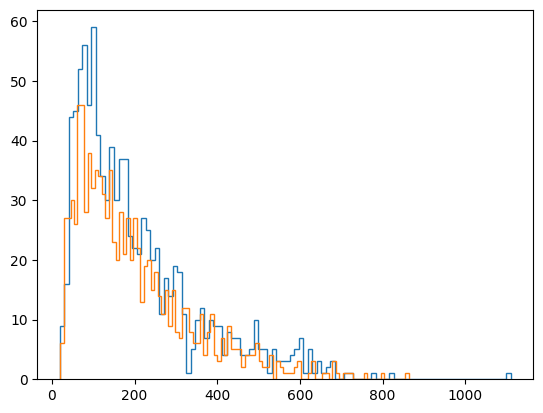

In [24]:
plt.hist(x_masses,bins=100, histtype='step',label='highest mass')
plt.hist(y_masses,bins=100, histtype='step',label='second hight mass')
plt.show()

In [25]:
#print(np.array(x_jets[2].constituents()))
constituents = [(x_jets[2].constituents()[i].m()) for i in range(len(x_jets[2].constituents()))]
print(constituents)

[-2.5809568279517847e-08, 0.0, -2.1073424255447017e-08, 1.0536712127723509e-08, 0.0, 1.0536712127723509e-08, 0.0, 0.0, -5.960464477539063e-08, 0.0, 2.9802322387695312e-08, 0.0, -2.1073424255447017e-08, 0.0, -4.2146848510894035e-08, 1.1920928955078125e-07, 1.1920928955078125e-07, 2.384185791015625e-07, -5.960464477539063e-08, 0.0, -3.371747880871523e-07, 0.0, 1.4600096599955427e-07, 0.0, 0.0, 2.384185791015625e-07, 1.6858739404357614e-07, 0.0, 2.384185791015625e-07, -8.429369702178807e-08, -1.6858739404357614e-07, 3.371747880871523e-07, -1.1920928955078125e-07, 8.429369702178807e-08, -3.371747880871523e-07, 3.371747880871523e-07, -8.429369702178807e-08, 0.0, 1.1920928955078125e-07, 1.1920928955078125e-07, -2.384185791015625e-07, 0.0, 2.384185791015625e-07, 2.9802322387695312e-08, 0.0, 0.0, 0.0, -1.3486991523486091e-06, -4.76837158203125e-07, 6.743495761743046e-07, 2.384185791015625e-07, -3.371747880871523e-07, -6.743495761743046e-07, -1.9073486328125e-06, 1.3486991523486091e-06, 0.0, 0.

In [71]:
# get padded constituents, relative coordinates and mask in the wanted format
constituents = []
rel_constituents = []
mask = []
jet_mass = []
jet_pt = []
jet_eta = []
jet_phi = []
len_padding = 300
for jet in x_jets:
    # get constituents
    const_pt = np.array([(jet.constituents()[i].perp()) for i in range(len(jet.constituents()))])
    const_eta = np.array([(jet.constituents()[i].eta()) for i in range(len(jet.constituents()))])
    const_phi = np.array([(jet.constituents()[i].phi_std()) for i in range(len(jet.constituents()))])
    consts = np.concatenate((const_pt[:,None],const_eta[:,None],const_phi[:,None]),axis=1)
    # sort constituents by pT from high to low
    consts = consts[np.argsort(consts[:, 0])[::-1]]
    
    # pad constituents and mask
    padded_consts = np.pad(consts,((0,len_padding-len(consts)),(0,0)),'constant',constant_values=0)
    padded_mask = np.pad(np.ones(len(consts)),(0,len_padding-len(consts)),'constant',constant_values=0)
    
    # relative coordinates
    rel_constituents_temp = padded_consts.copy()
    rel_constituents_temp[:, 0] = rel_constituents_temp[:, 0] / jet.perp()
    rel_constituents_temp[:, 1] = rel_constituents_temp[:, 1] - jet.eta()
    rel_constituents_temp[:, 2] = rel_constituents_temp[:, 2] - jet.phi_std()
    
    # fix phi range
    rel_constituents_temp[:, 2] = np.where(
        rel_constituents_temp[:, 2] >= np.pi,
        rel_constituents_temp[:, 2] - 2 * np.pi,
        rel_constituents_temp[:, 2],
    )
    rel_constituents_temp[:, 2] = np.where(
        rel_constituents_temp[:, 2] <= - np.pi,
        rel_constituents_temp[:, 2] + 2 * np.pi,
        rel_constituents_temp[:, 2],
    )
    
    # jet variables & append to list
    jet_mass.append(jet.m())
    jet_pt.append(jet.perp())
    jet_eta.append(jet.eta())
    jet_phi.append(jet.phi_std())
    constituents.append(padded_consts)
    rel_constituents.append(rel_constituents_temp)
    mask.append(padded_mask)
mask = np.array(mask)
constituents = np.array(constituents) * mask[:, :, None]
rel_constituents = np.array(rel_constituents)* mask[:, :, None]
jet_mass = np.array(jet_mass)
jet_pt = np.array(jet_pt)
jet_eta = np.array(jet_eta)
jet_phi = np.array(jet_phi)

print(constituents.shape)
print(rel_constituents.shape)
print(mask.shape)
print(f"max particle multipilicity: {np.max(np.sum(mask,axis=-1))}")
print(f"min particle multipilicity: {np.min(np.sum(mask,axis=-1))}")

(1000, 300, 3)
(1000, 300, 3)
(1000, 300)
max particle multipilicity: 169.0
min particle multipilicity: 8.0


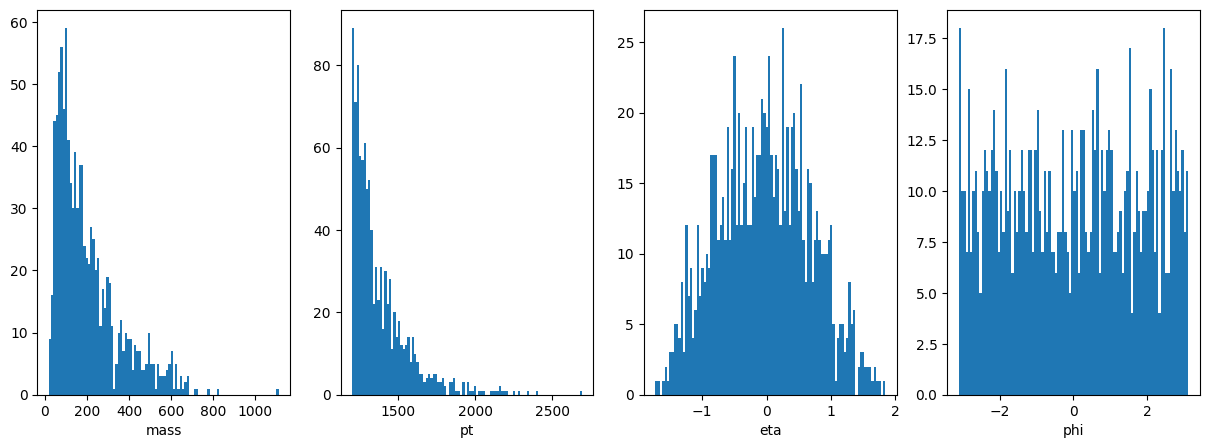

In [72]:
# Leading Jet Clustered Data
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_mass,bins=100)
axs[0].set_xlabel('mass')
axs[1].hist(jet_pt,bins=100)
axs[1].set_xlabel('pt')
axs[2].hist(jet_eta,bins=100)
axs[2].set_xlabel('eta')
axs[3].hist(jet_phi,bins=100)
axs[3].set_xlabel('phi')
plt.show()

In [75]:
print(constituents[5,:25])
print(rel_constituents[5,:25])

[[ 3.75192444e+02 -8.39323938e-01  1.96986169e-01]
 [ 2.93086426e+02 -8.40211213e-01  2.01787099e-01]
 [ 2.69415985e+02 -8.40773284e-01  1.98102474e-01]
 [ 2.41903885e+02 -8.39521289e-01  1.99222326e-01]
 [ 4.04148674e+01 -8.36298585e-01  2.24607781e-01]
 [ 3.87128563e+01 -8.26361716e-01  1.86376736e-01]
 [ 3.04461861e+01 -8.48331511e-01  2.14565068e-01]
 [ 1.60865154e+01 -7.93707132e-01  1.93925709e-01]
 [ 1.00796537e+01 -7.98361659e-01  2.01245531e-01]
 [ 5.16797829e+00 -8.28773320e-01  2.08990559e-01]
 [ 4.89354181e+00 -7.64914513e-01  2.45367140e-02]
 [ 4.44665575e+00 -8.70012879e-01  4.06829566e-01]
 [ 3.66794562e+00 -8.70925784e-01  2.32318074e-01]
 [ 3.59676886e+00 -8.55851352e-01  2.26882786e-01]
 [ 3.22263145e+00 -7.93649435e-01  2.66154021e-01]
 [ 2.75653410e+00 -8.48282158e-01  2.43766889e-01]
 [ 1.94910729e+00 -7.51675844e-01  2.97488391e-01]
 [ 1.71536469e+00 -8.75102460e-01  1.63929150e-01]
 [ 1.67619240e+00 -3.83511305e-01  7.42577672e-01]
 [ 1.58815777e+00 -7.25476742e-

In [78]:
print(mask[5,:25])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0.]


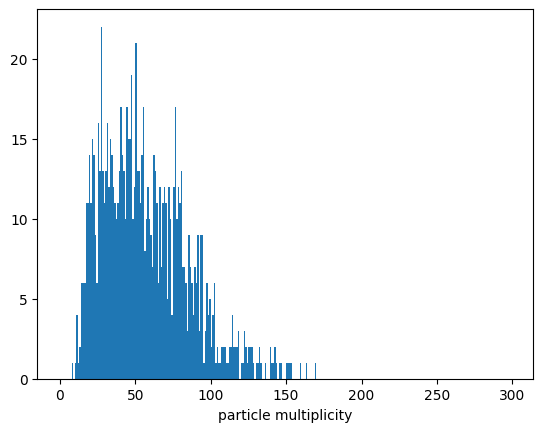

In [69]:
plt.hist(np.sum(mask,axis=-1), bins=range(0,300,1))
plt.xlabel('particle multiplicity')
plt.show()

In [77]:
# remove weird eta values
counter=0
for count_i,i in enumerate(rel_constituents):
    for count_j, j in enumerate(i):
        if j[1] > 1000:
            counter +=1
            print(count_i, count_j, j)
            rel_constituents[count_i,count_j,1] = 0
            rel_constituents[count_i,count_j,2] = 0
            mask[count_i,count_j] = 0
            print(rel_constituents[count_i,count_j,1])
        #else:
            #print(count_i, count_j, j[1])
print(counter)

5 23 [ 0.00000000e+00  1.00000838e+05 -2.00363382e-01]
0.0
14 122 [ 0.00000000e+00  1.00000804e+05 -5.38817266e-01]
0.0
17 44 [ 0.00000000e+00  9.99998754e+04 -9.01835515e-01]
0.0
26 43 [ 0.00000000e+00  1.00000774e+05 -1.87197887e-01]
0.0
28 54 [ 0.00000000e+00  1.00000609e+05 -5.95606678e-01]
0.0
35 39 [ 0.00000000e+00  1.00000584e+05 -5.42522934e-01]
0.0
52 65 [ 0.00000000e+00  9.99997529e+04 -2.74511563e-01]
0.0
55 22 [ 0.00000000e+00  1.00000267e+05 -4.50600832e-01]
0.0
71 68 [ 0.00000000e+00  1.00000047e+05 -2.00121774e-01]
0.0
72 24 [0.00000000e+00 9.99998185e+04 7.45366970e-01]
0.0
79 93 [0.00000000e+00 1.00000030e+05 1.36164624e-01]
0.0
88 75 [ 0.00000000e+00  1.00000466e+05 -8.15038179e-01]
0.0
106 26 [ 0.00000000e+00  9.99995740e+04 -3.85965763e-01]
0.0
119 31 [ 0.00000000e+00  1.00000323e+05 -6.48668965e-01]
0.0
124 22 [ 0.00000000e+00  1.00000103e+05 -2.19803282e-01]
0.0
137 49 [0.00000000e+00 9.99990599e+04 2.40624898e-01]
0.0
149 50 [ 0.00000000e+00  1.00000083e+05 -8.25

In [50]:
# remove weird eta values
counter=0
for count_i,i in enumerate(constituents):
    for count_j, j in enumerate(i):
        if j[1] > 1000:
            counter +=1
            print(count_i, count_j, j)
            constituents[count_i,count_j,1] = 0
            constituents[count_i,count_j,2] = 0
            print(constituents[count_i,count_j,1])
        #else:
            #print(count_i, count_j, j[1])
print(counter)

5 23 [     0. 100000.      0.]
0.0
14 122 [     0. 100000.      0.]
0.0
17 44 [     0. 100000.      0.]
0.0
26 43 [     0. 100000.      0.]
0.0
28 54 [     0. 100000.      0.]
0.0
35 39 [     0. 100000.      0.]
0.0
52 65 [     0. 100000.      0.]
0.0
55 22 [     0. 100000.      0.]
0.0
71 68 [     0. 100000.      0.]
0.0
72 24 [     0. 100000.      0.]
0.0
79 93 [     0. 100000.      0.]
0.0
88 75 [     0. 100000.      0.]
0.0
106 26 [     0. 100000.      0.]
0.0
119 31 [     0. 100000.      0.]
0.0
124 22 [     0. 100000.      0.]
0.0
137 49 [     0. 100000.      0.]
0.0
149 50 [     0. 100000.      0.]
0.0
151 56 [     0. 100000.      0.]
0.0
168 12 [     0. 100000.      0.]
0.0
180 26 [     0. 100000.      0.]
0.0
202 63 [     0. 100000.      0.]
0.0
211 93 [     0. 100000.      0.]
0.0
216 92 [     0. 100000.      0.]
0.0
218 13 [     0. 100000.      0.]
0.0
219 51 [     0. 100000.      0.]
0.0
232 50 [     0. 100000.      0.]
0.0
233 93 [     0. 100000.      0.]
0.0
235 51 [     

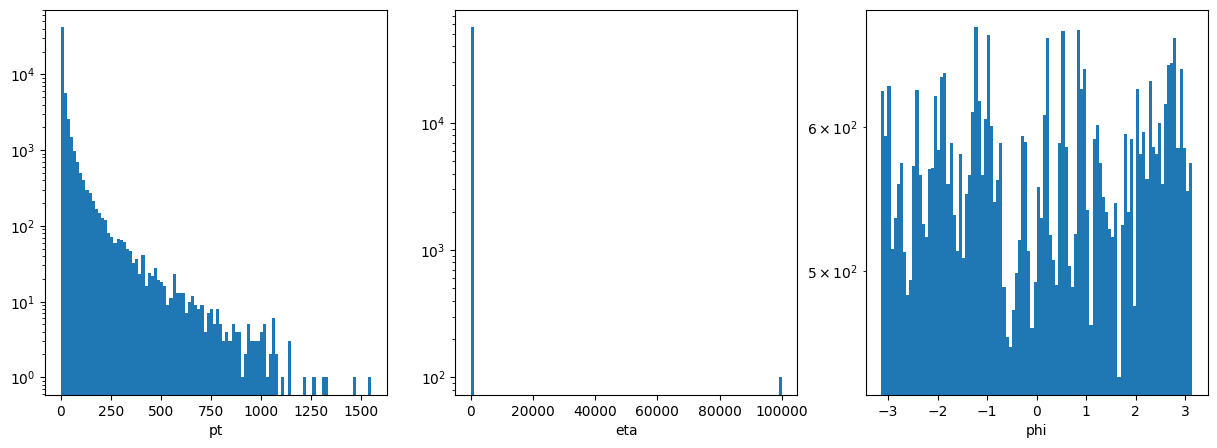

In [70]:

mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        constituents[:, :, index].flatten()[constituents[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
#plt.xlim(-5, 5)
plt.show()

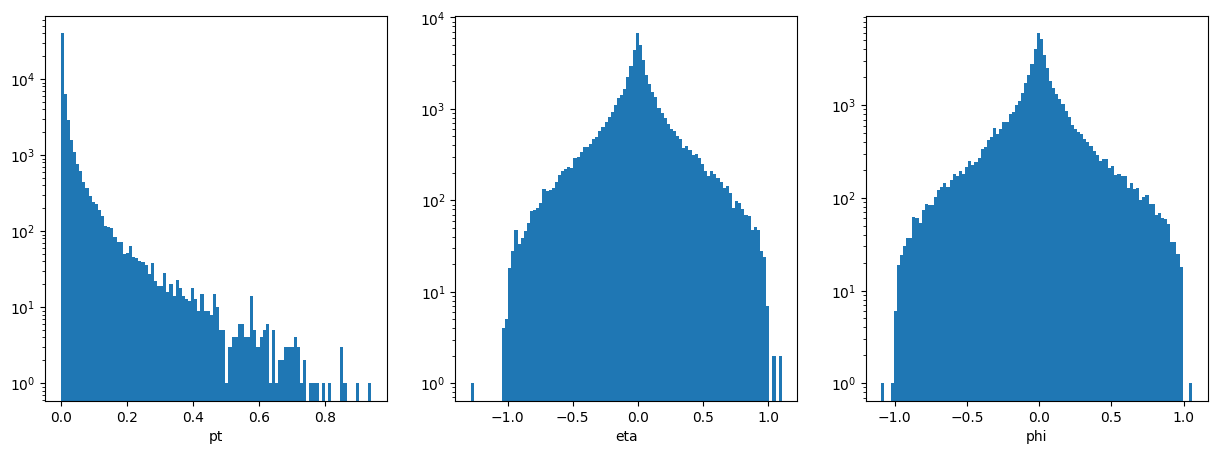

In [52]:
mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        rel_constituents[:, :, index].flatten()[rel_constituents[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
#plt.xlim(-5, 5)
plt.show()

In [59]:
p4s = ef.p4s_from_ptyphims(rel_constituents[:, :, :3])
sum_p4 = np.sum(p4s, axis=-2)
jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)

0.9999999999999988
1.0000000000000016


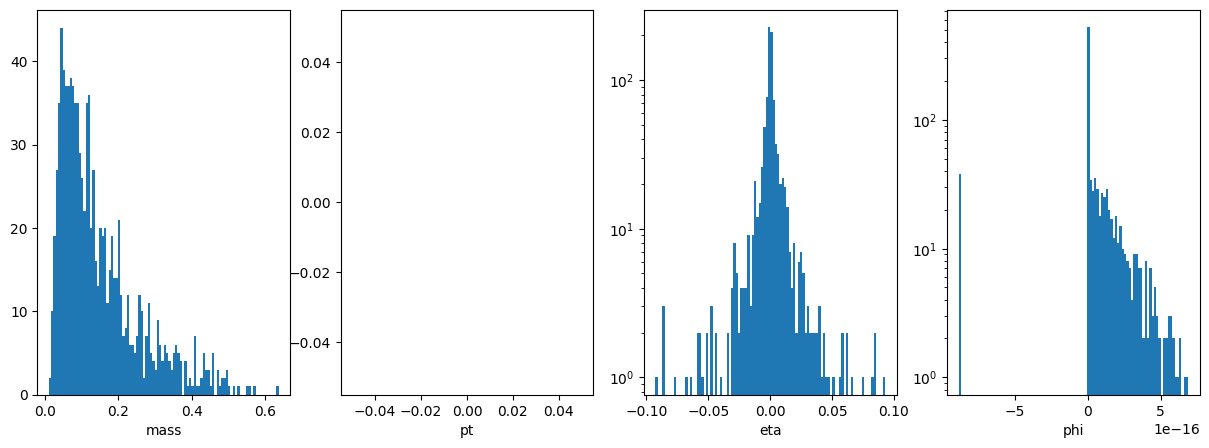

In [65]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_data[:,3],bins=100)
axs[0].set_xlabel('mass')
binwidth = 10
print(min(jet_data[:,0]))
print(max(jet_data[:,0]))
axs[1].hist(jet_data[:,0],bins=np.arange(0.99,1.01,0.1))
axs[1].set_xlabel('pt')
axs[2].hist(jet_data[:,1],bins=100)
axs[2].set_xlabel('eta')
axs[2].set_yscale('log')
axs[3].hist(jet_data[:,2],bins=100)
axs[3].set_xlabel('phi')
axs[3].set_yscale('log')
plt.show()

In [61]:
p4s_nr = ef.p4s_from_ptyphims(constituents[:, :, :3])
sum_p4_nr = np.sum(p4s_nr, axis=-2)
jet_data_nr = ef.ptyphims_from_p4s(sum_p4_nr, phi_ref=0)

1200.0473511711996
2694.002622385111


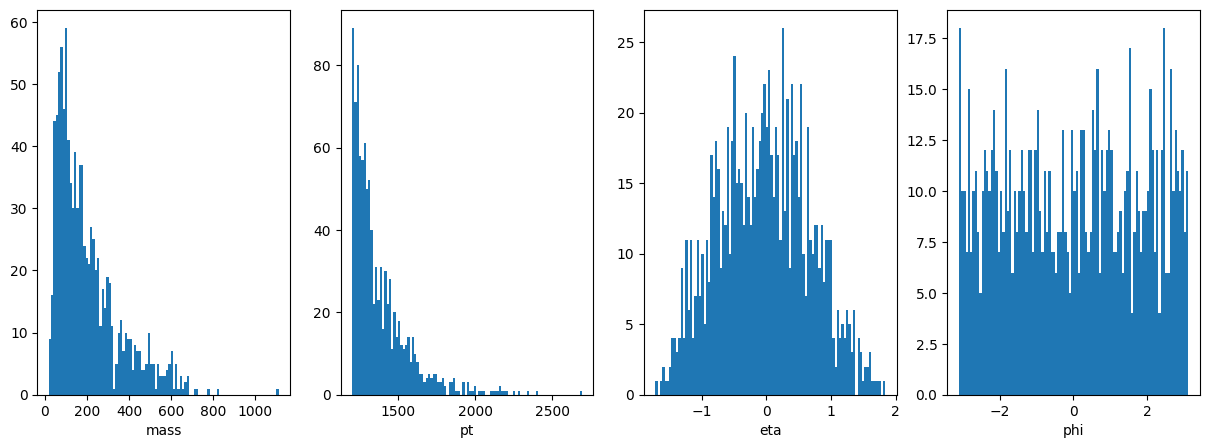

In [63]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_data_nr[:,3],bins=100)
axs[0].set_xlabel('mass')
print(min(jet_data_nr[:,0]))
print(max(jet_data_nr[:,0]))
axs[1].hist(jet_data_nr[:,0],bins=100)
axs[1].set_xlabel('pt')
axs[2].hist(jet_data_nr[:,1],bins=100)
axs[2].set_xlabel('eta')
axs[3].hist(jet_data_nr[:,2],bins=100)
axs[3].set_xlabel('phi')
plt.show()

# Load data

In [37]:
path = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2_processed.h5"
with h5py.File(path, "r") as f:
    rel_constituents = f["data"][:]
    mask = f["mask"][:]

In [38]:
print(rel_constituents.shape)
print(mask.shape)

(1000000, 300, 4)
(1000000, 300)


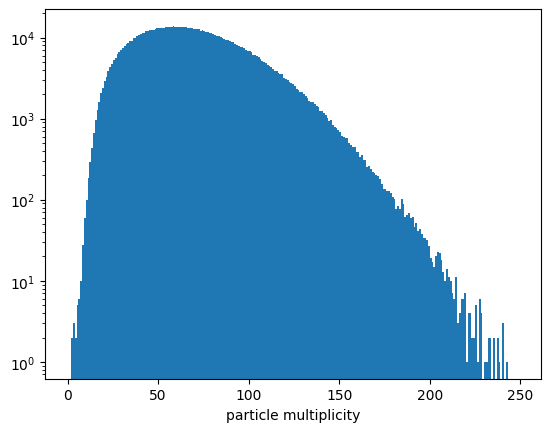

In [39]:
plt.hist(np.sum(mask, axis=-1), bins=range(0, 250, 1))
plt.xlabel("particle multiplicity")
plt.yscale("log")
plt.show()

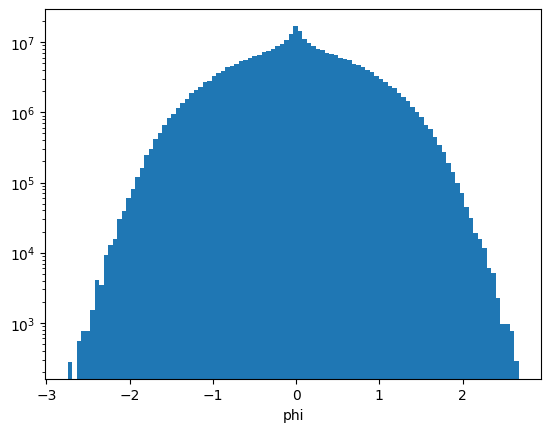

In [46]:
index = 1
plt.hist(
    rel_constituents[:, :, index].flatten()[rel_constituents[:, :, index].flatten() != 0], bins=100
)
plt.xlabel("phi")
plt.yscale("log")
plt.show()

In [41]:
p4s = ef.p4s_from_ptyphims(rel_constituents[:, :, :3])
sum_p4 = np.sum(p4s, axis=-2)
jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)

In [42]:
jet_data.shape

(1000000, 4)

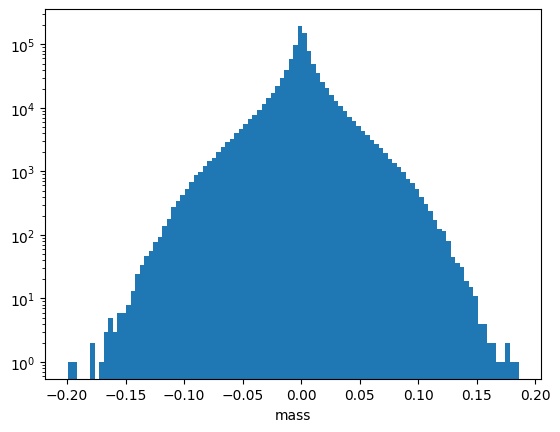

In [43]:
plt.hist(jet_data[:, 1], bins=100)
plt.yscale("log")
plt.xlabel("mass")
# plt.xlim(0.1+1e-12-1e-11,0.1+1e-12+1e-11)
plt.show()

In [44]:
data = rel_constituents[:, :, :3]
print(data.shape)

(1000000, 300, 3)


In [45]:
data2 = np.concatenate([data, np.expand_dims(mask, axis=-1)], axis=-1)
print(data2.shape)

(1000000, 300, 4)
